### Step 1: Load the packages

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")

g:\My Drive\APAC\Autopricing\Switchback Testing\switchback_test_dag\venv_sb\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


### Step 2.1: Read the SQL code and execute the query that pulls the data

In [57]:
# Read the query
path = "G:/My Drive/APAC/Autopricing/Vendor Clustering Automation/loved_brands_pairwise_simulation_tool/data_extraction_query.sql"
f = open(file=path, mode="r")
query = f.read()
f.close()

# Instantiate a BQ client
client = bigquery.Client(project="dh-logistics-product-ops")
bqstorage_client = bigquery_storage.BigQueryReadClient()

### Step 2.2: Run the query

In [9]:
client.query(query=query).result()

### Step 3.1: Pull the data from the generated tables

In [93]:
df = client\
    .query(query="""SELECT * FROM `dh-logistics-product-ops.pricing.asa_level_data_loved_brands_pairwise_simulation` ORDER BY entity_id, master_asa_id, is_lb_lm, tier_rank_master_asa""")\
    .to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

Downloading: 100%|██████████| 41807/41807 [00:03<00:00, 13728.15rows/s]


### Step 3.2: Change the data types of some columns

In [94]:
numeric_cols = [
       # Integer columns
       "master_asa_id",
       "vendor_count_caught_by_asa",
       "tier_rank_master_asa",
       "num_tiers_master_asa",
       "order_count_vendor_cluster_tt_fee_level",
       "order_count_vendor_cluster_level",
       "order_count_master_asa_level",
       "order_count_entity_level",
       "previous_order_count_vendor_cluster_tt_fee_level",
       
       # Float columns
       "fee",
       "min_tt_fee_master_asa_level",
       "df_revenue_local_vendor_cluster_tt_fee_level",
       "df_revenue_eur_vendor_cluster_tt_fee_level",
       "vendor_gmv_local_vendor_cluster_tt_fee_level",
       "vendor_gmv_eur_vendor_cluster_tt_fee_level",
       "gp_local_vendor_cluster_tt_fee_level",
       "gp_eur_vendor_cluster_tt_fee_level",
       "vendor_cluster_order_share_of_entity",
       "master_asa_order_share_of_entity",
       "df_revenue_local_vendor_cluster_level", "df_revenue_eur_vendor_cluster_level",
       "gmv_local_vendor_cluster_level", "gmv_eur_vendor_cluster_level", 
       "gp_local_vendor_cluster_level", "gp_eur_vendor_cluster_level",
       "previous_fee_vendor_cluster_tt_fee_level",
       "tier_elasticity_vendor_cluster_level",
       "fee_pct_diff_vendor_cluster_level"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

### Step 4.1: Flag the outlier elasticity values

In [95]:
# Create a list of grouping variables. They will be used in several steps below
grouping_vars = ["region", "entity_id", "country_code", "master_asa_id", "asa_common_name", "is_asa_clustered", "is_lb_lm"]

# Filter for rows with non-null elasticity values
df_no_null_elasta = df.loc[df["tier_elasticity_vendor_cluster_level"].notnull(), :]

# Create a grouped object
df_grouped = df_no_null_elasta.groupby(grouping_vars, as_index=False)["tier_elasticity_vendor_cluster_level"]

df_q25_elasta = df_grouped.apply(np.percentile, q=25).rename(columns=dict(tier_elasticity_vendor_cluster_level= "q25")) # type: ignore
df_q75_elasta = df_grouped.apply(np.percentile, q=75).rename(columns=dict(tier_elasticity_vendor_cluster_level= "q75")) # type: ignore

# Join df_q25_elasta and df_q75_elasta to df
df = df\
    .merge(right=df_q25_elasta, on=grouping_vars, how="left")\
    .merge(right=df_q75_elasta, on=grouping_vars, how="left")

# Calculate the IQR, upper bound and lower bound
df["iqr"] = df["q75"] - df["q25"]
df["lower_bound"] = df["q25"] - 1.5 * df["iqr"]
df["upper_bound"] = df["q75"] + 1.5 * df["iqr"]
df["is_elasticity_remove"] = np.where(
    (np.isnan(df["tier_elasticity_vendor_cluster_level"])) | # If elasticity value is NaN
    (df["tier_elasticity_vendor_cluster_level"] < df["lower_bound"]) | # ... or below lower bound
    (df["tier_elasticity_vendor_cluster_level"] > df["upper_bound"]), # ... or above upper bound
    True, # Value of flag if the condition evaluates to True
    False # Value of flag if the condition evaluates to False
)

### Step 4.2: Remove the outlier elasticity values and calculate the average and median elasticity per vendor cluster

In [96]:
df_agg_elasticity = df[df["is_elasticity_remove"] == False]\
    .groupby(grouping_vars)["tier_elasticity_vendor_cluster_level"]\
    .agg(['median', 'mean'], axis=1)\
    .rename(columns={"median": "median_cluster_elasticity", "mean": "mean_cluster_elasticity"})\
    .reset_index()

df = pd.merge(left = df, right=df_agg_elasticity, on=grouping_vars, how="left")

### Step 4.3: Apply a linear model to the elasticity data to obtain a slope and an intercept

In [97]:
# Define a function that fits a line through the elasticity data points
def lm_model_fee_elasticity(df):
    data_x = df[~df["tier_elasticity_vendor_cluster_level"].isnull()]["fee"].values.reshape(-1,1)
    data_y = df[~df["tier_elasticity_vendor_cluster_level"].isnull()]["tier_elasticity_vendor_cluster_level"].values.reshape(-1,1)
    # sample_weight = df[~df["previous_order_count_vendor_cluster_tt_fee_level"].isnull()]["previous_order_count_vendor_cluster_tt_fee_level"].values
    sample_weight = df[~df["tier_elasticity_vendor_cluster_level"].isnull()]["previous_order_count_vendor_cluster_tt_fee_level"].values
    lm = LinearRegression()
    lm.fit(X=data_x, y=data_y, sample_weight=sample_weight)
    return float(np.squeeze(lm.coef_)), float(np.squeeze(lm.intercept_))

In [98]:
# Define a function that fits a line through the fee x order count per TT fee tier curve
def lm_model_tt_fee_curve(df):
    data_x = df[~df["order_count_vendor_cluster_tt_fee_level"].isnull()]["fee"].values.reshape(-1,1)
    data_y = df[~df["order_count_vendor_cluster_tt_fee_level"].isnull()]["order_count_vendor_cluster_tt_fee_level"].values.reshape(-1,1)
    sample_weight = df[~df["order_count_vendor_cluster_tt_fee_level"].isnull()]["order_count_vendor_cluster_tt_fee_level"].values
    lm = LinearRegression()
    lm.fit(X=data_x, y=data_y, sample_weight=sample_weight)
    return float(np.squeeze(lm.coef_)), float(np.squeeze(lm.intercept_))

In [99]:
# Create a function to apply the linear model to get the slope and intercept
def apply_lm_model(dataframe, model, slope_col_name, intercept_col_name, which_model): # which_model can be "elasticity" or "tt_fee"
    if which_model == "elasticity":
        df_lm_elasticity = dataframe[dataframe["is_elasticity_remove"] == False]\
            .groupby(grouping_vars)\
            .apply(model)  # type: ignore
    else:
        df_lm_elasticity = dataframe\
            .groupby(grouping_vars)\
            .apply(model)  # type: ignore

    # Split the slope_intercept tuple into two columns
    df_lm_elasticity = pd.DataFrame(df_lm_elasticity, columns=["slope_intercept"])
    df_lm_elasticity[[slope_col_name, intercept_col_name]] = pd.DataFrame(df_lm_elasticity['slope_intercept'].tolist(), index=df_lm_elasticity.index)
    df_lm_elasticity.reset_index(drop=False, inplace=True)

    # Join "df_lm_elasticity" to "df"
    dataframe = pd.merge(left = dataframe, right=df_lm_elasticity.drop(labels="slope_intercept", axis=1), on=grouping_vars, how="left").reset_index(drop=True)
    
    if which_model == "elasticity":
        return dataframe
    else:
        return df_lm_elasticity

In [100]:
# Apply the fee x elasticity linear model
df = apply_lm_model(dataframe=df, model=lm_model_fee_elasticity, slope_col_name="ela_lm_slope", intercept_col_name="ela_lm_intercept", which_model="elasticity")

# Apply the fee x orders linear model
# Create a dataframe containing the ASA IDs with enough orders. These are the ASAs with which the linear regression won't throw an error 
df_zero_order_asas = df.groupby(grouping_vars, as_index=False)["order_count_vendor_cluster_tt_fee_level"].sum()
df_zero_order_asas["is_zero_order_asa"] = np.where(df_zero_order_asas["order_count_vendor_cluster_tt_fee_level"] == 0, "Y", "N")
df_zero_order_asas = df_zero_order_asas[df_zero_order_asas["is_zero_order_asa"] == "N"]

df_tt_fee_curve_lm = apply_lm_model(
    dataframe=pd.merge(left=df, right=df_zero_order_asas.drop("order_count_vendor_cluster_tt_fee_level", axis=1), on=grouping_vars, how="inner"),
    model=lm_model_tt_fee_curve, slope_col_name="tt_fee_curve_lm_slope", intercept_col_name="tt_fee_curve_lm_intercept", which_model="tt_fee"
)

df = pd.merge(left=df, right=df_tt_fee_curve_lm.drop("slope_intercept", axis=1), on=grouping_vars, how="left")

### Step 4.4: Obtain the aggregated metrics per vendor cluster

In [101]:
# Create a list of variables that can be aggregated
agg_vars = [
    "vendor_count_caught_by_asa", "num_tiers_master_asa",
    "order_count_vendor_cluster_level", "order_count_master_asa_level", "order_count_entity_level", "vendor_cluster_order_share_of_entity", "master_asa_order_share_of_entity",
    "tot_revenue_local_vendor_cluster_level", "tot_revenue_eur_vendor_cluster_level",
    "df_revenue_local_vendor_cluster_level", "df_revenue_eur_vendor_cluster_level",
    "gmv_local_vendor_cluster_level", "gmv_eur_vendor_cluster_level",
    "gp_local_vendor_cluster_level", "gp_eur_vendor_cluster_level",
    "median_cluster_elasticity", "mean_cluster_elasticity", "ela_lm_slope", "ela_lm_intercept", "tt_fee_curve_lm_slope", "tt_fee_curve_lm_intercept"
]

# Calculate the weighted average TT fee of each vendor cluster
df_avg_df = df\
    .groupby(grouping_vars, as_index=False)\
    .apply(lambda x: sum(x["fee"] * x["order_count_vendor_cluster_tt_fee_level"]) / sum(x["order_count_vendor_cluster_tt_fee_level"]))

df_avg_df.rename(columns={None: "order_wtd_avg_df_local"}, inplace=True)  # type: ignore

# Aggregate the metrics defined above
df_vendor_cluster_agg = df.groupby(grouping_vars, as_index=False)[agg_vars].mean()
df_vendor_cluster_agg = df_vendor_cluster_agg.assign(
    gpo_eur = df_vendor_cluster_agg["gp_eur_vendor_cluster_level"] / df_vendor_cluster_agg["order_count_vendor_cluster_level"],
    gpo_local = df_vendor_cluster_agg["gp_local_vendor_cluster_level"] / df_vendor_cluster_agg["order_count_vendor_cluster_level"],
    gmv_per_order_eur = df_vendor_cluster_agg["gmv_eur_vendor_cluster_level"] / df_vendor_cluster_agg["order_count_vendor_cluster_level"],
    gmv_per_order_local = df_vendor_cluster_agg["gmv_local_vendor_cluster_level"] / df_vendor_cluster_agg["order_count_vendor_cluster_level"],
    df_pct_gmv = df_vendor_cluster_agg["df_revenue_eur_vendor_cluster_level"] / df_vendor_cluster_agg["gmv_eur_vendor_cluster_level"],
    df_pct_revenue = df_vendor_cluster_agg["df_revenue_eur_vendor_cluster_level"] / df_vendor_cluster_agg["tot_revenue_eur_vendor_cluster_level"]
)

# Join "df_vendor_cluster_agg" and "df_avg_df"
df_vendor_cluster_agg = pd.merge(left=df_vendor_cluster_agg, right=df_avg_df, on=grouping_vars, how="left")

### Step 4.5: Create a function that models out the projected profit and gmv

In [102]:
def kpi_model_func(df, avg_df_chng_lb, avg_df_chng_non_lb):
    # Create a new column giving the avg DF change per vendor cluster
    df["avg_df_chng"] = np.where(df["is_lb_lm"] == "Y", avg_df_chng_lb, avg_df_chng_non_lb)

    # The model is based on TT fee against elasticity, so we need a new TT fee value to calculate the new elasticity
    df["order_wtd_avg_df_local_new"] = df["order_wtd_avg_df_local"] * (1 + df["avg_df_chng"])
    
    # Calculate the impact on GP and GMV from the avg DF change
    df = df.assign(
        gpo_impact = df["avg_df_chng"] * df["df_pct_revenue"],
        gmv_impact = df["avg_df_chng"] * df["df_pct_gmv"]
    )

    # Calculate the projected elasticity from the "avg_df_chng" field
    df = df.assign(
        exp_elasticity = df["ela_lm_slope"] * df["order_wtd_avg_df_local_new"] + df["ela_lm_intercept"]
    )

    # Calculate the projected GPO, GMV per order, total order volume
    df = df.assign(
        exp_gpo_eur = np.where(
            df["gpo_eur"] > 0,
            df["gpo_eur"] * (1 + df["gpo_impact"]),
            df["gpo_eur"] * (1 - df["gpo_impact"])
        ), # To deal with negative GPO values
        exp_gpo_local = np.where(
            df["gpo_local"] > 0,
            df["gpo_local"] * (1 + df["gpo_impact"]),
            df["gpo_local"] * (1 - df["gpo_impact"])
        ), # To deal with negative GPO values

        exp_gmv_per_order_eur = df["gmv_per_order_eur"] * (1 + df["gmv_impact"]),
        exp_gmv_per_order_local = df["gmv_per_order_local"] * (1 + df["gmv_impact"]),
        # exp_order_count = (1 + (df["avg_df_chng"] * df["median_cluster_elasticity"])) * df["order_count_vendor_cluster_level"] # Using the median cluster elasticity
        exp_order_count = ((df["avg_df_chng"] * df["exp_elasticity"]) + 1) * df["order_count_vendor_cluster_level"] # Using the elasticity from the linear model
    )

    # The np.where method changes the data type of "exp_gpo_eur" and "exp_gpo_local" to "object", which causes the rest of the functions to fail. Change the data type back to numeric
    df[["exp_gpo_eur", "exp_gpo_local"]] = df[["exp_gpo_eur", "exp_gpo_local"]].apply(pd.to_numeric)

    # Calculate the projected total gross profit and GMV
    df = df.assign(
        exp_tot_gp_eur = df["exp_gpo_eur"] * df["exp_order_count"],
        exp_tot_gp_local = df["exp_gpo_local"] * df["exp_order_count"],
        exp_tot_gmv_eur = df["exp_gmv_per_order_eur"] * df["exp_order_count"],
        exp_tot_gmv_local = df["exp_gmv_per_order_local"] * df["exp_order_count"]
    )

    # Overall (two groups summed)
    df_result_overall = df\
        .groupby(["region", "entity_id", "country_code", "master_asa_id", "asa_common_name", "is_asa_clustered"])["exp_tot_gp_eur", "exp_tot_gp_local", "exp_tot_gmv_eur", "exp_tot_gmv_local"]\
        .sum()\
        .reset_index()
    df_result_overall = df_result_overall.assign(
        avg_df_chng_lb = avg_df_chng_lb,
        avg_df_chng_non_lb = avg_df_chng_non_lb
    )

    # The "groupby" - "sum" operation above changes all "None" to "0". These "0" values come from ASAs whose median_cluster_elasticity is None because they have one DF tier
    return df, df_result_overall

### Step 4.6: Loop over different avg DF changes for LBs and non-LBs to construct a dataset that can be used for the heatmaps

In [134]:
df_model = []
df_raw = []
lb_avg_df_chng = np.arange(start=-0.15, stop=0.16, step=0.01).round(2).tolist()
non_lb_avg_df_chng = np.arange(start=-0.15, stop=0.16, step=0.01).round(2).tolist()

for lb in lb_avg_df_chng:
    for nlb in non_lb_avg_df_chng:
        df_vendor_cluster_agg_iter, df_result_overall_iter = kpi_model_func(df=df_vendor_cluster_agg, avg_df_chng_lb=lb, avg_df_chng_non_lb=nlb)
        df_model.append(df_result_overall_iter)
        df_raw.append(df_vendor_cluster_agg_iter)
    
df_model = pd.concat(df_model)
df_raw = pd.concat(df_raw)
df_model = df_model.reset_index(drop=True)
df_raw = df_raw.reset_index(drop=True)

### Step 4.7: Calculate the order count, median elasticity, and median and average expected LM elasticity per vendor group

In [135]:
# Create a list of columns that will form the dataset
supp_data_cols = grouping_vars.copy()
supp_data_cols.extend(["tt_fee_curve_lm_slope", "order_count_vendor_cluster_level", "median_cluster_elasticity", "exp_elasticity"]) # Add three columns to the grouping_vars list

# Create the dataset
df_supp_data = df_raw[supp_data_cols].drop_duplicates().reset_index(drop=True) # type: ignore

# Aggregate the metrics
df_supp_data = df_supp_data\
    .groupby(grouping_vars, as_index=False)\
    .agg({"tt_fee_curve_lm_slope": "mean", "order_count_vendor_cluster_level": "mean", "median_cluster_elasticity": "mean", "exp_elasticity": "median"})

### Step 5: Upload the resulting table to BQ

In [105]:
job_config = bigquery.LoadJobConfig()
job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

job = client.load_table_from_dataframe(
    dataframe=df_supp_data, # type: ignore
    destination="dh-logistics-product-ops.pricing.lb_raw_results_pairwise_simulation",
    job_config=job_config
).result()

In [106]:
job = client.load_table_from_dataframe(
    dataframe=df_model, # type: ignore
    destination="dh-logistics-product-ops.pricing.lb_model_results_pairwise_simulation",
    job_config=job_config
).result()

In [107]:
# Upload a data frame containing information about the order shares per TT fee to simplify the use of the DBDF optimizer
job = client.load_table_from_dataframe(
    dataframe=df[["region", "entity_id", "country_code", "master_asa_id", "asa_common_name", "is_asa_clustered", "is_lb_lm", "fee", "order_count_vendor_cluster_tt_fee_level"]],
    destination="dh-logistics-product-ops.pricing.order_shares_per_tt_fee_tier_pairwise_simulation",
    job_config=job_config
).result()

In [108]:

# Upload a data frame containing information about the order-weighted avg DF changes to simplify the use of the DBDF optimizer
order_wtd_avg_df_changes = df_raw.groupby(["region", "entity_id", "country_code", "master_asa_id", "asa_common_name", "is_asa_clustered", "is_lb_lm", "avg_df_chng"], as_index=False)["avg_df_chng", "order_wtd_avg_df_local", "order_wtd_avg_df_local_new"]\
    .mean()\
    .sort_values(by=["entity_id", "master_asa_id", "is_lb_lm", "avg_df_chng"])

job = client.load_table_from_dataframe(
    dataframe=order_wtd_avg_df_changes,
    destination="dh-logistics-product-ops.pricing.order_wtd_avg_tt_fee_changes_pairwise_simulation",
    job_config=job_config
).result()

### Step 6: Validate the theory that stark differences in elasticities yield diverging recommendations from LBs and non-LBs

In [136]:
# Prepare the data
common_cols_val_theory = df_supp_data.columns[df_supp_data.columns != "is_lb_lm"].tolist()
grouping_cols_val_theory = ["region", "entity_id", "country_code", "master_asa_id", "asa_common_name", "is_asa_clustered"]
df_left_val_theory = df_supp_data[df_supp_data["is_lb_lm"] == "Y"][common_cols_val_theory]
df_right_val_theory = df_supp_data[df_supp_data["is_lb_lm"] == "N"][common_cols_val_theory]

# Combine both data frames
df_val_theory = pd.merge(left=df_left_val_theory, right=df_right_val_theory, how="left", on=grouping_cols_val_theory, suffixes=["_lb", "_nlb"])

# Create two new columns showing the elasticity ratios according to the LM and the raw data
df_val_theory = df_val_theory.assign(
    diff_exp_lm_elasticity = df_val_theory["exp_elasticity_lb"] - df_val_theory["exp_elasticity_nlb"], # Calculate the difference between the LB and non-LB expected LM elasticity ratio
    exp_lm_elasticity_ratio = df_val_theory["exp_elasticity_nlb"] / df_val_theory["exp_elasticity_lb"],
    raw_elasticity_ratio = df_val_theory["median_cluster_elasticity_nlb"] / df_val_theory["median_cluster_elasticity_lb"],
    tt_fee_curve_lm_ratio = df_val_theory["tt_fee_curve_lm_slope_nlb"] / df_val_theory["tt_fee_curve_lm_slope_lb"]
)

In [141]:
df_val_theory[(df_val_theory["entity_id"] == "FP_MY")][["master_asa_id", "tt_fee_curve_lm_ratio", "exp_lm_elasticity_ratio", "raw_elasticity_ratio", "diff_exp_lm_elasticity"]].sort_values(by="diff_exp_lm_elasticity", ascending=False).head(20)

,master_asa_id,tt_fee_curve_lm_ratio,exp_lm_elasticity_ratio,raw_elasticity_ratio,diff_exp_lm_elasticity
520,246,-1.557674,0.282998,1.093111,3.681908
444,16,-0.612170,0.484375,1.463149,1.879556
463,97,12.604252,0.386180,1.019830,1.752017
486,154,1.405119,12.162375,1.084948,1.464177
464,111,-0.119994,0.398349,2.407827,1.456624
518,212,-585.577279,-0.958642,1.503833,1.279099
512,183,-5.397918,-0.149024,0.423140,0.788889
452,74,2.695460,-0.981442,1.448937,0.744963
465,121,7.983707,1.432850,1.419282,0.743964
511,182,2.268679,-6.354295,1.600841,0.664917


In [137]:
# Upload df_val_theory to BQ
job = client.load_table_from_dataframe(
    dataframe=df_val_theory,
    destination="dh-logistics-product-ops.pricing.asa_finder_pairwise_simulation",
    job_config=job_config
).result()

### Step 7: Miscellaneous Charts 

(-10.0, 10.0)

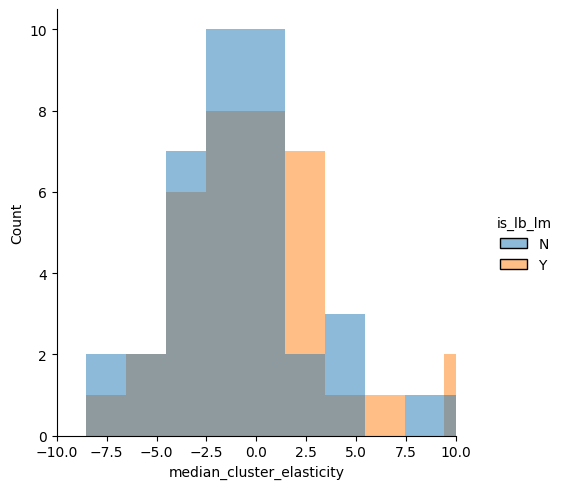

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(data = df_vendor_cluster_agg[df_vendor_cluster_agg["entity_id"] == "PY_AR"], x = "median_cluster_elasticity", hue="is_lb_lm")
plt.xlim(-10,10)